# 2.Data acquaintance and Pre-processing

# Importing the libraries needed.

In [1]:
import psycopg2
import psycopg2.extras
import pandas as pd
import numpy
import shapely
import geopandas as gpd
import numpy as np
import helper
import calendar
import os, sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style


In [2]:
PLT_FIG_WIDTH = 7
PLT_FIG_HEIGHT = 3

# Connect to the Postgres DB in order to acquire the raw ais data and the static data.

In [3]:
con = psycopg2.connect(database='geoinfo',  
                       user='postgres',     
                       password='markos1310',  
                       host='localhost',  
                       port=5432)

In [4]:
cursor = con.cursor()

In [5]:
sql_query1 = 'SELECT * FROM unipi_ais_feb_2018_raw;' #february ais
feb_geodf = gpd.GeoDataFrame.from_postgis(sql_query1, con, geom_col='geom')

In [6]:
sql_query2 = 'SELECT * FROM unipi_ais_mar_2018_raw;' #march ais

mar_geodf = gpd.GeoDataFrame.from_postgis(sql_query2, con, geom_col='geom')

In [7]:
 sql_query3='SELECT * FROM ais_static;'#static data

In [8]:
 cursor.execute(sql_query3)

In [9]:
columns_names = ['mmsi','imo','vessel_name','vessel_flag','vessel_type']

In [10]:
static_df= pd.DataFrame(cursor.fetchall(),columns=columns_names)

In [11]:
len(static_df) #inital length of staic data

65658

In [12]:
static_df.head()

,mmsi,imo,vessel_name,vessel_flag,vessel_type
0,0,NaN,None,NO FLAG,None
1,56,9152985.0,HARMONY,NO FLAG,Oil Products Tanker
2,83,9037501.0,NIM WAN,NO FLAG,Container Ship
3,95,6325745.0,RSS BRAVE,NO FLAG,Other Type
4,98,9264594.0,PV DARING,NO FLAG,Not available


In [13]:
feb_geodf.sort_values('timestmp', inplace=True)#sort data by timestamp

In [14]:
len(feb_geodf) #initial length of ais in February (after the spatial outliers removal)

6104342

In [15]:
mar_geodf.sort_values('timestmp', inplace=True)#sort data by timestamp

In [16]:
len(mar_geodf) #initial length of ais in March (after the spatial outliers removal)

6701297

In [17]:
feb_geodf.head()

,mmsi,timestmp,geom,lon,lat,speed,ais_type,ais_status,ais_heading,ais_turn,ais_course
160676,237017200,1517436000000,POINT (23.56900 37.95528),23.568995,37.955283,0.0,None,None,NaN,None,0.1
160677,319092600,1517436000000,POINT (23.64761 37.93285),23.647613,37.932847,0.0,None,None,135.0,None,314.3
160678,235100119,1517436001000,POINT (23.68193 37.93263),23.681927,37.932628,0.0,None,None,242.0,None,259.1
160679,237008100,1517436002000,POINT (23.64102 37.94490),23.641023,37.944897,0.0,None,None,NaN,None,NaN
99,239864200,1517436004000,POINT (23.61501 37.94470),23.615015,37.944697,0.0,None,None,NaN,None,207.7


In [18]:
mar_geodf.head()

,mmsi,timestmp,geom,lon,lat,speed,ais_type,ais_status,ais_heading,ais_turn,ais_course
241124,636013190,1519855200000,POINT (23.53934 37.88567),23.539338,37.885675,1.4,None,None,44.0,None,15.5
241125,241024000,1519855201000,POINT (23.65010 37.93166),23.650097,37.931657,0.0,None,None,332.0,None,178.1
241126,237991700,1519855201000,POINT (23.54615 37.94995),23.546150,37.949950,0.0,None,None,NaN,None,268.0
241127,239722800,1519855201000,POINT (23.63220 37.94397),23.632205,37.943968,0.0,None,None,NaN,None,0.0
241128,239550200,1519855201000,POINT (23.64085 37.94716),23.640850,37.947157,0.0,None,None,264.0,None,142.1


## 2.1 Clean the noise 

In [19]:
def static_data_preprocessing(sdf):
    sdf=sdf.dropna() #delete every row with at least one nan value
    sdf= sdf[sdf.vessel_flag != 'NO FLAG'] #delete rows that has the values NO FLAG
    return sdf

In [20]:
static_df=static_data_preprocessing(static_df)

In [21]:
len(static_df) #the length of the static dataset after the preprocessing.

63877

In [22]:
def data_preprocessing(geo_df):
    geo_df.drop_duplicates(subset=['mmsi','timestmp'], inplace=True)#drop duplicates
    geo_df.dropna(subset=['timestmp','speed'], inplace=True) #drop nan values
    geo_df=geo_df.loc[geo_df['mmsi'].isin(static_df['mmsi'])] #drop values that are not registered in static dataset.
    geo_df=geo_df.loc[geo_df.speed < 50].copy() #drop values where the speed surpasses the 50 knots threshold
    #Converting time from msec. to sec.
    geo_df.loc[:, 'timestamp_sec'] = geo_df.timestmp/10**3
    geo_df=geo_df.rename(columns={'speed':'velocity'})
    #Calculate acceleration
    geo_df = geo_df.groupby('mmsi', group_keys=False).apply(lambda gdf: helper.calculate_acceleration(gdf, ts_column='timestamp_sec'))
    return geo_df

In [23]:
final_feb_geodf=data_preprocessing(feb_geodf)

In [24]:
len(final_feb_geodf) #the final length of the February dataset.

4960765

In [25]:
final_feb_geodf.head()

,mmsi,timestmp,geom,lon,lat,velocity,ais_type,ais_status,ais_heading,ais_turn,ais_course,timestamp_sec,acceleration
160676,237017200,1517436000000,POINT (23.56900 37.95528),23.568995,37.955283,0.0,None,None,NaN,None,0.1,1.517436e+09,0.0
160679,237008100,1517436002000,POINT (23.64102 37.94490),23.641023,37.944897,0.0,None,None,NaN,None,NaN,1.517436e+09,0.0
98,239737000,1517436004000,POINT (23.62549 37.94088),23.625490,37.940883,0.0,None,None,152.0,None,0.0,1.517436e+09,0.0
97,249136000,1517436004000,POINT (23.59589 37.95244),23.595890,37.952443,0.0,None,None,348.0,None,313.1,1.517436e+09,0.0
100,239299000,1517436005000,POINT (23.65033 37.93317),23.650333,37.933167,0.0,None,None,187.0,None,140.0,1.517436e+09,0.0


In [26]:
final_mar_geodf=data_preprocessing(mar_geodf)

In [27]:
len(final_mar_geodf)#the final length of the March dataset.

5116284

In [28]:
final_mar_geodf.head()

,mmsi,timestmp,geom,lon,lat,velocity,ais_type,ais_status,ais_heading,ais_turn,ais_course,timestamp_sec,acceleration
241124,636013190,1519855200000,POINT (23.53934 37.88567),23.539338,37.885675,1.4,None,None,44.0,None,15.5,1.519855e+09,-0.01
241125,241024000,1519855201000,POINT (23.65010 37.93166),23.650097,37.931657,0.0,None,None,332.0,None,178.1,1.519855e+09,0.00
241126,237991700,1519855201000,POINT (23.54615 37.94995),23.546150,37.949950,0.0,None,None,NaN,None,268.0,1.519855e+09,0.00
241127,239722800,1519855201000,POINT (23.63220 37.94397),23.632205,37.943968,0.0,None,None,NaN,None,0.0,1.519855e+09,0.00
241128,239550200,1519855201000,POINT (23.64085 37.94716),23.640850,37.947157,0.0,None,None,264.0,None,142.1,1.519855e+09,0.00


# 2.2 Sampling Rate Histogram

# Calculating the sampling rate by weekday and Plot the results with bar plot.

## SAMPLING RATE BY WEEKDAY IN FEBRUARY

In [33]:
total_records_per_feb_wd = final_feb_geodf.groupby([pd.to_datetime(final_feb_geodf.timestmp, unit="ms").dt.date]).apply(len).to_frame().reset_index()
total_records_per_feb_wd.loc[:, 'day_name'] = pd.to_datetime(total_records_per_feb_wd.timestmp).dt.day_name()
total_records_per_feb_wd.loc[:, 'day_name'] = pd.Categorical(total_records_per_feb_wd.day_name, categories=list(calendar.day_name), ordered=True)
total_records_per_feb_wd.sort_values('day_name', inplace=True)
total_records_per_feb_wd=total_records_per_feb_wd.groupby(total_records_per_feb_wd.day_name).apply(sum)

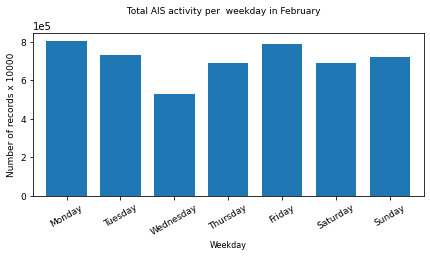

In [34]:
total_records_per_feb_wd.plot.bar(cmap='tab20', figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=9, width=0.75, legend=False, rot=30)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r' Total AIS activity per  weekday in February', fontsize=9, y=1)
plt.xlabel(r'Weekday', fontsize=8)
plt.ylabel(r'Number of records x 10000', fontsize=9)
#plt.savefig('./total_ais_feb.png')
plt.show()

## SAMPLING RATE BY WEEKDAY IN MARCH 

In [36]:
total_records_per_mar_wd = final_mar_geodf.groupby([pd.to_datetime(final_mar_geodf.timestmp, unit="ms").dt.date]).apply(len).to_frame().reset_index()
total_records_per_mar_wd.loc[:, 'day_name'] = pd.to_datetime(total_records_per_mar_wd.timestmp).dt.day_name()
total_records_per_mar_wd.loc[:, 'day_name'] = pd.Categorical(total_records_per_mar_wd.day_name, categories=list(calendar.day_name), ordered=True)
total_records_per_mar_wd.sort_values('day_name', inplace=True)
total_records_per_mar_wd=total_records_per_mar_wd.groupby(total_records_per_mar_wd.day_name).apply(sum)

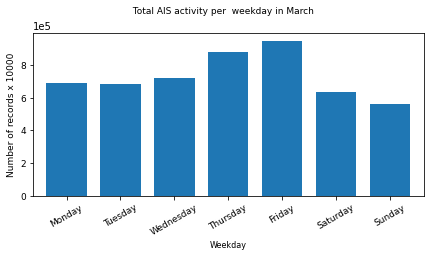

In [36]:
total_records_per_mar_wd .plot.bar(cmap='tab20', figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=9, width=0.75, legend=False, rot=30)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r' Total AIS activity per  weekday in March', fontsize=9, y=1)
plt.xlabel(r'Weekday', fontsize=8)
plt.ylabel(r'Number of records x 10000', fontsize=9)
#plt.savefig('./total_ais_mar.png')
plt.show()

## Calculate the  average sampling rate per weekday and Plot the results with a line plot.

## AVERAGE SAMPLING RATE PER WEEKDAY IN FEBRUARY 

In [72]:
avg_records_per_feb_wd = final_feb_geodf.groupby([pd.to_datetime(final_feb_geodf.timestmp, unit="ms").dt.date]).apply(len).to_frame().reset_index()
avg_records_per_feb_wd.loc[:, 'day_name'] = pd.to_datetime(avg_records_per_feb_wd.timestmp).dt.day_name()
avg_records_per_feb_wd.loc[:, 'day_name'] = pd.Categorical(avg_records_per_feb_wd.day_name, categories=list(calendar.day_name), ordered=True)
avg_records_per_feb_wd.sort_values('day_name', inplace=True)

avg_records_per_feb_wd=avg_records_per_feb_wd.groupby(avg_records_per_feb_wd.day_name).apply(sum)/avg_records_per_feb_wd.sum()

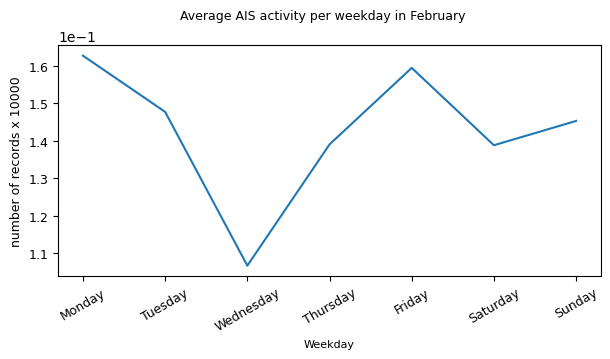

In [74]:
avg_records_per_feb_wd.plot.line(cmap='tab20', figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=9, legend=False, rot=30)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r' Average AIS activity per weekday in February', fontsize=9, y=1)
plt.xlabel(r'Weekday', fontsize=8)
plt.ylabel(r'number of records x 10000', fontsize=9)
#plt.savefig('./avg_ais_feb.png')
plt.show()

## AVERAGE SAMPLING RATE PER WEEKDAY IN MARCH 

In [69]:
avg_records_per_mar_wd = final_mar_geodf.groupby([pd.to_datetime(final_mar_geodf.timestmp, unit="ms").dt.date]).apply(len).to_frame().reset_index()
avg_records_per_mar_wd.loc[:, 'day_name'] = pd.to_datetime(avg_records_per_mar_wd.timestmp).dt.day_name()
avg_records_per_mar_wd.loc[:, 'day_name'] = pd.Categorical(avg_records_per_mar_wd.day_name, categories=list(calendar.day_name), ordered=True)
avg_records_per_mar_wd.sort_values('day_name', inplace=True)

avg_records_per_mar_wd=avg_records_per_mar_wd.groupby(avg_records_per_mar_wd.day_name).apply(sum)/avg_records_per_mar_wd.sum()

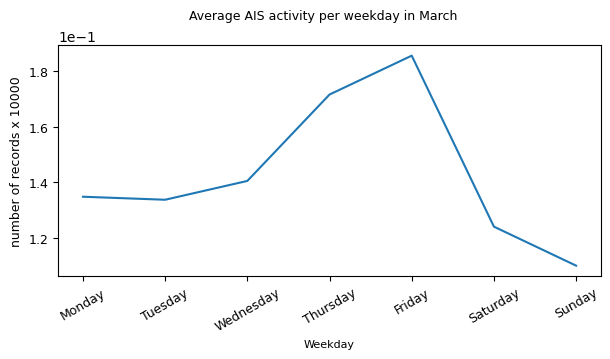

In [75]:
avg_records_per_mar_wd.plot.line(cmap='tab20', figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=9, legend=False, rot=30)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r' Average AIS activity per weekday in March', fontsize=9, y=1)
plt.xlabel(r'Weekday', fontsize=8)
plt.ylabel(r'number of records x 10000', fontsize=9)
#plt.savefig('./avg_ais_mar.png')
plt.show()

# 2.3 Calculating the acceleration rate and plot the result

## ACCELERATION RATE IN FEBRUARY

Text(0, 0.5, '#records')

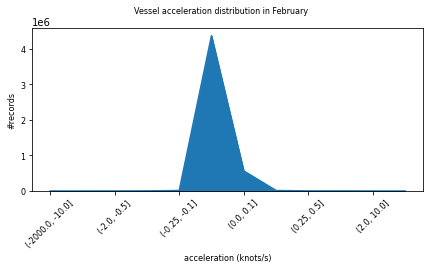

In [41]:
no_of_bins=[-2000, -10, -2, -0.5, -0.25, -0.1, 0, 0.1, 0.25, 0.5, 2, 10, 2000] 

out = pd.cut(final_feb_geodf.acceleration, no_of_bins)
ax = out.value_counts(sort=False).plot.area(figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=8, cmap='tab20', rot=45)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'Vessel acceleration distribution in February', fontsize=8)
plt.xlabel(r'acceleration (knots/s)', fontsize=8)
plt.ylabel(r'#records', fontsize=8)
#plt.savefig('./acc_ais_feb.png')
plt.show()

## ACCELERATION RATE IN MARCH 

Text(0, 0.5, '#records')

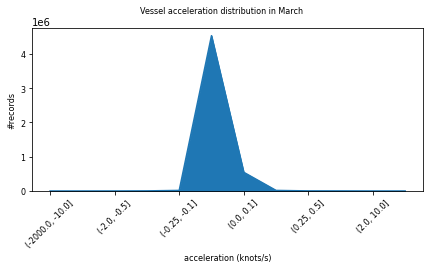

In [42]:
no_of_bins=[-2000, -10, -2, -0.5, -0.25, -0.1, 0, 0.1, 0.25, 0.5, 2, 10, 2000] 

out = pd.cut(final_mar_geodf.acceleration, no_of_bins)
ax = out.value_counts(sort=False).plot.area(figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=8, cmap='tab20', rot=45)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'Vessel acceleration distribution in March', fontsize=8)
plt.xlabel(r'acceleration (knots/s)', fontsize=8)
plt.ylabel(r'#records', fontsize=8)
#plt.savefig('./acc_ais_mar.png')
plt.show()

## VESSEL SPEED DISTRIBUTION IN FEBRUARY 

Text(0, 0.5, '#recordsx10000')

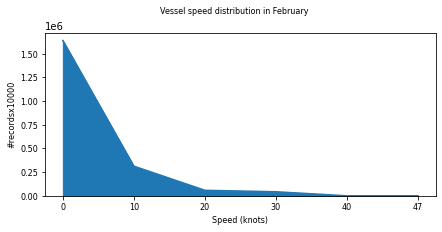

In [43]:
out = pd.cut(final_feb_geodf.velocity, [0, 10, 20, 30, 40, np.round(final_feb_geodf.velocity.max()), np.round(final_feb_geodf.velocity.max())+2])
ax = out.value_counts(sort=False).plot.area(figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=8, cmap='tab20', rot=0)
ax.set_xticklabels([''] + out.cat.categories.left.values.astype(int).tolist() + [''])

plt.suptitle(r'Vessel speed distribution in February', fontsize=8, y=1)
plt.xlabel(r'Speed (knots)', fontsize=8)
plt.ylabel(r'#recordsx10000', fontsize=8)
plt.savefig('./speed_ais_feb.png')
plt.show()

## VESSEL SPEED DISTRIBUTION IN MARCH 

Text(0, 0.5, '#recordsx10000')

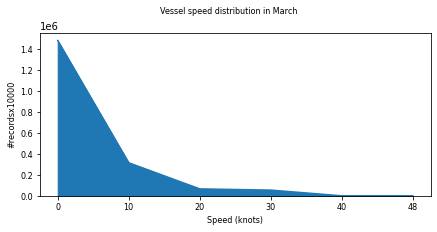

In [44]:
out = pd.cut(final_mar_geodf.velocity, [0, 10, 20, 30, 40, np.round(final_mar_geodf.velocity.max()), np.round(final_mar_geodf.velocity.max())+2])
ax = out.value_counts(sort=False).plot.area(figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=8, cmap='tab20', rot=0)
ax.set_xticklabels([''] + out.cat.categories.left.values.astype(int).tolist() + [''])

plt.suptitle(r'Vessel speed distribution in March', fontsize=8, y=1)
plt.xlabel(r'Speed (knots)', fontsize=8)
plt.ylabel(r'#recordsx10000', fontsize=8)
plt.savefig('./speed_ais_mar.png')
plt.show()

## Save the cleansed data in csv files.

In [55]:
#final_df=final_feb_geodf.append(final_mar_geodf)

In [56]:
#len(final_df)

10077049

In [49]:
#final_feb_geodf=final_feb_geodf.drop(columns=['timestamp_sec'])
#final_mar_geodf=final_mar_geodf.drop(columns=['timestamp_sec'])

In [58]:
#final_df.to_csv('./unipi_ais_feb_mar_2018_clean.csv', header=True, index=False ,sep=';')

In [52]:
#final_feb_geodf.to_csv('./unipi_ais_feb_2018_clean.csv', header=True, index=False ,sep=';')

In [53]:
#final_mar_geodf.to_csv('./unipi_ais_mar_2018_clean.csv', header=True, index=False ,sep=';')